In [2]:
from calendar import month

import numpy as np
import pandas as pd
from holidays import country_holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import itertools
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import uniform 
import joblib
import os

#### Load and prepare the dataset

In [3]:
# Load and prepare the dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)

# Sort dataframe by date in descending order
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

# Filter data up to 30th October 2024
df = df[df['Datetime'] <= '2024-10-29 23:59:00']

# Filter data for the last 6 months
end_date = df['Datetime'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].reset_index(drop=True)

# Rename columns to fit Prophet requirements
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)
# actual 29th October 2024
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]

#outliers clipped
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Fourier Order including Actual Data

In [ ]:
model = Prophet(
 #   growth= 'linear',
 #   daily_seasonality=True,  # Turn off daily seasonality (add custom seasonality)
 #   yearly_seasonality=True,  # Allow yearly seasonality for longer trends
    weekly_seasonality=True,  # Allow weekly seasonality
 #   changepoint_prior_scale=0.05, # Default changepoint flexibility
    n_changepoints= 7,
 #   seasonality_mode= 'additive',
 #   seasonality_prior_scale = 0.01,
 #   holidays_prior_scale = 0.01,

)
# Adding custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=480)
model.add_seasonality(name='daily', period=24, fourier_order=50)
#model.add_seasonality(name='weekly', period=7*24, fourier_order=7)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=500)
model.add_seasonality(name='yearly', period=365.25, fourier_order=1000)

# Fit the model
model.fit(df)
future = pd.date_range(start='2024-10-29 00:00:00', end='2024-10-29 23:59:00', freq='h')
future_df = pd.DataFrame({'ds': future})

In [5]:
# Forecast the future values
forecast = model.predict(future_df)

# Merge actual and forecast data for October 29th
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
merged_data = pd.merge(actual_29th[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate RMSE for October 29th
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for October 29th, 2024: {rmse}")

RMSE for October 29th, 2024: 5.753559566263798


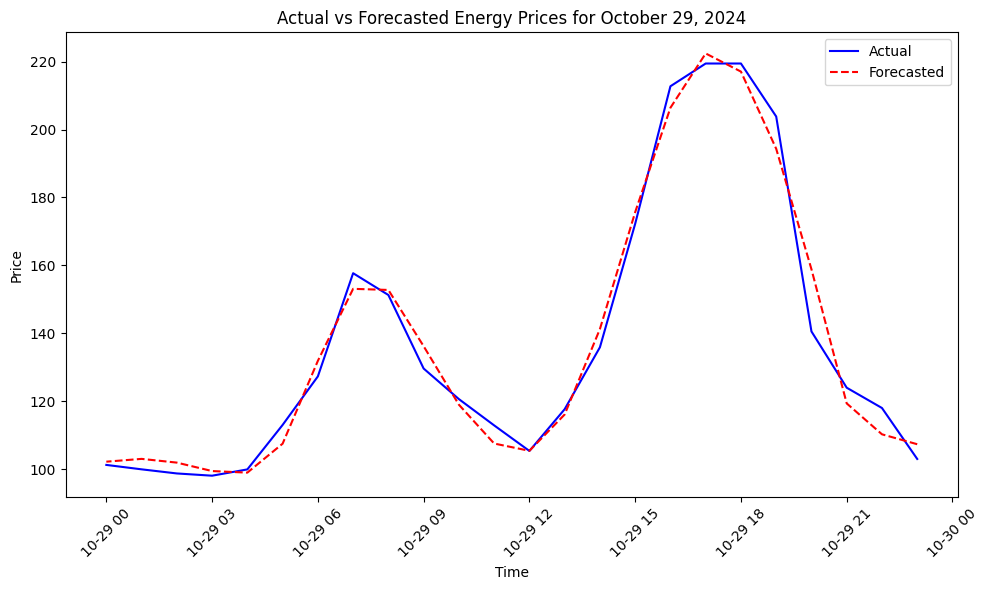

RMSE for October 29th, 2024: 5.753559566263798


In [7]:
# Plot the forecast vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(merged_data['ds'], merged_data['y'], label='Actual', color='blue')
plt.plot(merged_data['ds'], merged_data['yhat'], label='Forecasted', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for October 29, 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print the RMSE
print(f"RMSE for October 29th, 2024: {rmse}")

In [9]:
# Pickle the model
from datetime import datetime
import pickle
import os
import matplotlib.pyplot as plt
import json

# Create timestamp for unique folder naming
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
rmse_str = f"{rmse:.2f}"  # Format RMSE with two decimal points

# Define directory for this model
base_dir = '/Users/zeynepkaya/PycharmProjects/LSDI-Project-/models/Prophet/pickle'
model_dir = os.path.join(base_dir, f"model_{rmse_str}_rmse_{ts}")
os.makedirs(model_dir, exist_ok=True)

# Save Prophet model to the directory
pickle_path = os.path.join(model_dir, 'model.pickle')
with open(pickle_path, "wb") as file:
    pickle.dump(model, file)

# Collect all hyperparameters from the model
hyperparams = {
    'growth': model.growth,
    'changepoint_prior_scale': model.changepoint_prior_scale,
    'seasonality_mode': model.seasonality_mode,
    'daily_seasonality': model.daily_seasonality,
    'yearly_seasonality': model.yearly_seasonality,
    'weekly_seasonality': model.weekly_seasonality,
    'seasonality_prior_scale': model.seasonality_prior_scale,
    'holidays_prior_scale': model.holidays_prior_scale,
    'n_changepoints': model.n_changepoints,
    'seasonalities': model.seasonalities,  # Custom seasonalities
    'holidays': model.holidays.to_json() if model.holidays is not None else None  # Convert holidays to JSON if present
}

# Save hyperparameters to JSON file
json_path = os.path.join(model_dir, 'hyperparams.json')
with open(json_path, 'w') as json_file:
    json.dump(hyperparams, json_file, indent=4)

# Plot Actual vs Forecasted and save
plt.figure(figsize=(10, 6))
plt.plot(merged_data['ds'], merged_data['y'], label='Actual', color='blue')
plt.plot(merged_data['ds'], merged_data['yhat'], label='Forecasted', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for October 29, 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Save the plot as an image
plot_path = os.path.join(model_dir, 'actual_vs_forecast.png')
plt.savefig(plot_path)
plt.close()


# Train/Test & Fourier Order NOT including Actual Data

In [133]:
# Load and prepare the dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Keep 29th october actual data
#actual_data = df[df['ds'] <= '2024-10-29 23:59:00']

# Filter data up to 30th October 2024
df = df[df['ds'] <= '2024-10-29 23:59:00']
end_date = df['ds'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)].reset_index(drop=True)

#outliers clipped
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Split data: Use the last 20% as test data, and the first 80% as training data
split_index = int(len(df) * 0.2)  # 80% for training, 20% for testing
test_data = df[:split_index]  # First 80% for training
train_data = df[split_index:]   # Remaining 20% for testing


### The Prophet Model

In [134]:
# Initialize and configure the Prophet model
model = Prophet(
    growth= 'linear',
    daily_seasonality=False, # Turn off daily seasonality (add custom seasonality)
   # yearly_seasonality=True,  # Allow yearly seasonality for longer trends
   # weekly_seasonality=True,  # Allow weekly seasonality
    changepoint_prior_scale= 0.5, # Default changepoint flexibility
    n_changepoints= 5,
    seasonality_mode= 'additive',
    seasonality_prior_scale = 0.01,
    holidays_prior_scale = 0.01,

)

# Add custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=2)
model.add_seasonality(name='daily', period=24, fourier_order=12)
model.add_seasonality(name='weekly', period=7*24, fourier_order=1)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
model.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

# Fit the model on the training data
model.fit(train_data)

# Define future dates for forecasting (test period)
future_df = test_data[['ds']]  # Using the test data for future forecasting

# Forecast the future values (test period)
forecast = model.predict(future_df)

20:13:30 - cmdstanpy - INFO - Chain [1] start processing
20:13:30 - cmdstanpy - INFO - Chain [1] done processing


In [135]:
#RMSE
# Merge actual and forecast data for comparison
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data[(merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for the test period: {rmse}")

rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024: {rmse_29th_october}")



RMSE for the test period: 54.68512500029602
RMSE for 29th October 2024: 44.82103705085119


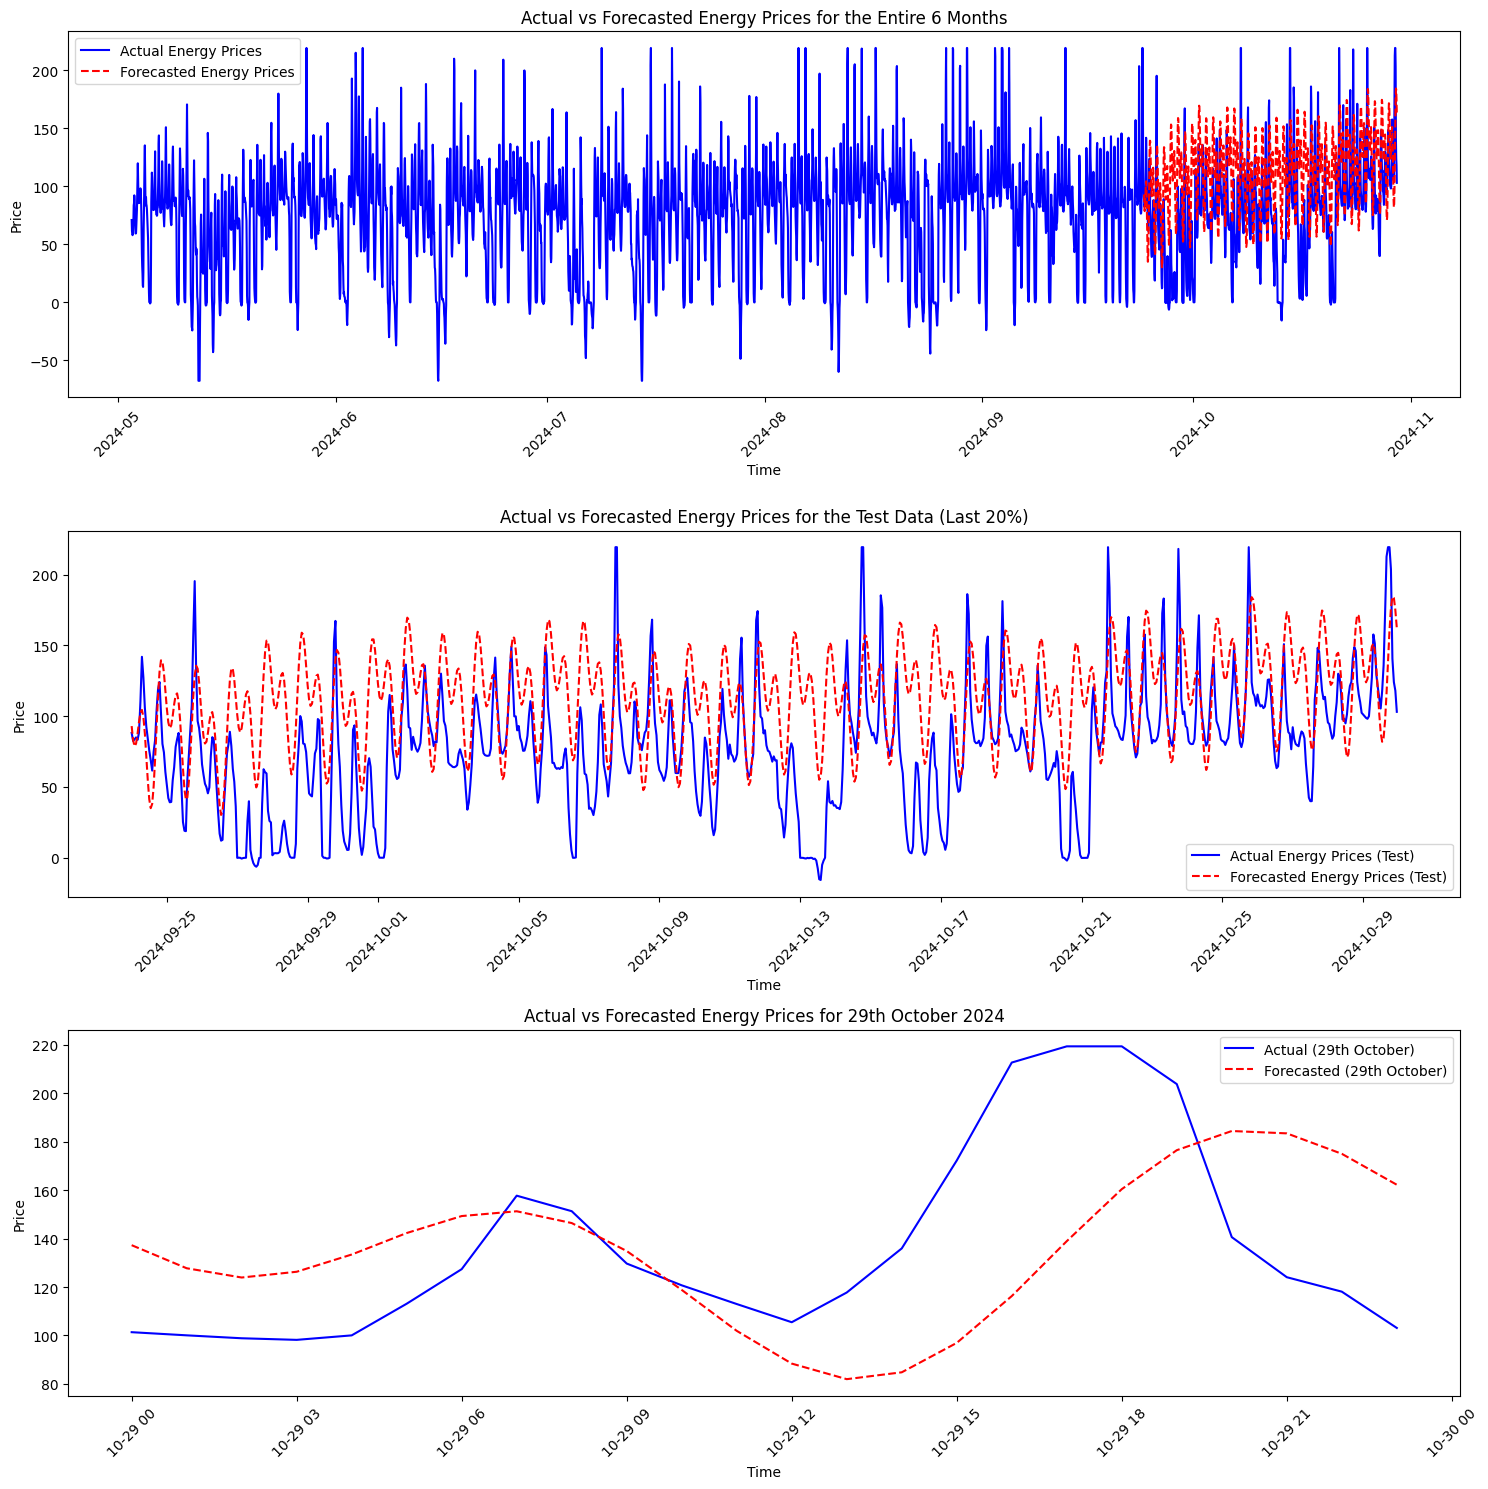

In [136]:
# Plot the entire data with forecasted and actual values
plt.figure(figsize=(15, 15))

# Plot entire data (train + test) with forecast and actual values
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot only test data (last 20%)
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices (Test)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot 29th October 2024 data separately
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast[forecast['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue')
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()


plt.tight_layout()
plt.show()


In [29]:
# pickle
from datetime import datetime
import pickle
import os
import matplotlib.pyplot as plt
import json

# Create timestamp for unique folder naming
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
rmse_str = f"{rmse_29th_october:.2f}"  # Format RMSE with two decimal points

# Define directory for this model
base_dir = '/Users/zeynepkaya/PycharmProjects/LSDI-Project-/models/Prophet/pickle'
model_dir = os.path.join(base_dir, f"model_{rmse_str}_rmse_{ts}")
os.makedirs(model_dir, exist_ok=True)

# Save Prophet model to the directory
pickle_path = os.path.join(model_dir, 'model.pickle')
with open(pickle_path, "wb") as file:
    pickle.dump(model, file)

# Collect all hyperparameters from the model
hyperparams = {
    'growth': model.growth,
    'changepoint_prior_scale': model.changepoint_prior_scale,
    'seasonality_mode': model.seasonality_mode,
    'daily_seasonality': model.daily_seasonality,
    'yearly_seasonality': model.yearly_seasonality,
    'weekly_seasonality': model.weekly_seasonality,
    'seasonality_prior_scale': model.seasonality_prior_scale,
    'holidays_prior_scale': model.holidays_prior_scale,
    'n_changepoints': model.n_changepoints,
    'seasonalities': model.seasonalities,  # Custom seasonalities
    'holidays': model.holidays.to_json() if model.holidays is not None else None  # Convert holidays to JSON if present
}

# Save hyperparameters to JSON file
json_path = os.path.join(model_dir, 'hyperparams.json')
with open(json_path, 'w') as json_file:
    json.dump(hyperparams, json_file, indent=4)

# Plot Entire 6 Months with Forecasted and Actual Values
plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot Test Data with Forecasted and Actual Values
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices (Test)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot 29th October 2024 Data
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast[forecast['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue')
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Save the third plot
plot_path_29october = os.path.join(model_dir, 'actual_vs_forecast_29october.png')
plt.savefig(plot_path_29october)

# Ensure the layout is tight before closing
plt.tight_layout()
plt.close()

# Final print statement
print("All plots have been saved successfully.")


All plots have been saved successfully.


In [ ]:
# Load the JSON configuration file/ if need
with open('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/models/Prophet/pickle/model_44.88_rmse_20241204_160210/hyperparams.json', 'r') as f:
    config = json.load(f)

# Initialize and configure the Prophet model with values from the JSON configuration
model = Prophet(
    growth=config['growth'],
    changepoint_prior_scale=config['changepoint_prior_scale'],
    seasonality_mode=config['seasonality_mode'],
    daily_seasonality=config['daily_seasonality'],
    yearly_seasonality=config['yearly_seasonality'],
    weekly_seasonality=config['weekly_seasonality'],
    seasonality_prior_scale=config['seasonality_prior_scale'],
    holidays_prior_scale=config['holidays_prior_scale'],
    n_changepoints=config['n_changepoints']
)

# Add custom seasonalities from the JSON configuration
for seasonality_name, seasonality_params in config['seasonalities'].items():
    model.add_seasonality(
        name=seasonality_name,
        period=seasonality_params['period'],
        fourier_order=seasonality_params['fourier_order'],
        prior_scale=seasonality_params['prior_scale'],
        mode=seasonality_params['mode']
    )

# Fit the model on the training data
model.fit(train_data)

# Define future dates for forecasting (test period)
future_df = test_data[['ds']]  # Using the test data for future forecasting

# Forecast the future values (test period)
forecast = model.predict(future_df)

# Merge actual and forecast data for comparison
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data[(merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')]

# Calculate RMSE for the entire test period
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for the test period: {rmse}")

# Calculate RMSE for 29th October 2024
rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024: {rmse_29th_october}")


In [ ]:
# Hyperparameter grid
# import itertools
from sklearn.metrics import mean_squared_error

# Define the function for optimizing seasonality
def optimize_seasonality(train_data, test_data):
    best_rmse = float('inf')  # Initialize best RMSE
    best_params = {}  # Initialize best parameters

    # Define parameter grids for each seasonality
    hourly_fourier_orders = [1, 2, 3]
    daily_fourier_orders = [8, 10, 12, 15]
    weekly_fourier_orders = [1, 2, 3]
    monthly_fourier_orders = [10, 20, 30, 40]
    yearly_fourier_orders = [1, 3, 5]

    # Generate all possible combinations of parameters
    param_combinations = list(itertools.product(
        hourly_fourier_orders,
        daily_fourier_orders,
        weekly_fourier_orders,
        monthly_fourier_orders,
        yearly_fourier_orders
    ))

    # Iterate through each parameter combination
    for params in param_combinations:
        hourly, daily, weekly, monthly, yearly = params

        # Initialize Prophet model
        model = Prophet(
            growth='linear',
            changepoint_prior_scale=0.5,
            n_changepoints=12,
            seasonality_mode='additive',
            seasonality_prior_scale=0.01,
            holidays_prior_scale=0.01,
            daily_seasonality=False  # Turn off built-in daily seasonality
        )

        # Add custom seasonalities with current parameters
        model.add_seasonality(name='hourly', period=1, fourier_order=hourly)
        model.add_seasonality(name='daily', period=24, fourier_order=daily)
        model.add_seasonality(name='weekly', period=7 * 24, fourier_order=weekly)
        model.add_seasonality(name='monthly', period=30.5 * 24, fourier_order=monthly)
        model.add_seasonality(name='yearly', period=365.25 * 24, fourier_order=yearly)

        # Fit the model
        model.fit(train_data)

        # Define future dates for forecasting (test period)
        future_df = test_data[['ds']]  # Using the test data for future forecasting

        # Forecast the future values (test period)
        forecast = model.predict(future_df)

        # Merge actual and forecast data for comparison
        merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

        # Filter merged_data to include only the data for 29th October 2024
        merged_data_29th = merged_data[(merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')]

        # Calculate RMSE for the entire test period
        rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))

        # Calculate RMSE for 29th October 2024
        rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))

        # Print RMSE results for this combination
        print(f"Combination: Hourly={hourly}, Daily={daily}, Weekly={weekly}, Monthly={monthly}, Yearly={yearly}")
        print(f"RMSE (Test Period): {rmse}, RMSE (29th Oct): {rmse_29th_october}")

        # Update the best RMSE and parameters if this is the best combination
        if rmse_29th_october < best_rmse:
            best_rmse = rmse_29th_october
            best_params = {
                'hourly_fourier_order': hourly,
                'daily_fourier_order': daily,
                'weekly_fourier_order': weekly,
                'monthly_fourier_order': monthly,
                'yearly_fourier_order': yearly
            }

    return best_rmse, best_params

# Run the optimization function
best_rmse, best_params = optimize_seasonality(train_data, test_data)

# Print the best RMSE and the corresponding parameters
print(f"Best RMSE (29th October 2024): {best_rmse}")
print(f"Best Seasonality Parameters: {best_params}")

# Best Seasonality Parameters:
# {'hourly_fourier_order': 2,
# 'daily_fourier_order': 12,
# 'weekly_fourier_order': 2,
# 'monthly_fourier_order': 30, '
# yearly_fourier_order': 5}


# Cross-Validation

In [54]:
# Load dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv',
                 parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Filter data up to 30th October 2024
df = df[df['ds'] <= '2024-10-29 23:59:00']
end_date = df['ds'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)].reset_index(drop=True)

# Outliers clipped
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Split data: Use the last 20% as test data, and the first 80% as training data
split_index = int(len(df) * 0.2)  # 80% for training, 20% for testing
test_data = df[:split_index]  # First 80% for training
train_data = df[split_index:]  # Remaining 20% for testing


In [ ]:
# Hyperparameter grid for cross-validation

horizon_values = ['3 days', '5 days']
initial_values = ['130 days', '120 days']
period_values = ['10 days', '5 days']

# Create all combinations of hyperparameters using Cartesian product
hyperparameter_grid = list(product(horizon_values, initial_values, period_values))

# Best parameters and lowest RMSE initialization
best_rmse_cv = float('inf')
best_params = None

# Cross-validation settings for Prophet
for horizon, initial, period in hyperparameter_grid:
    print(f"Training with parameters: horizon={horizon}, initial={initial}, period={period}")

    # Initialize Prophet model
    model = Prophet(
        growth='linear',
        changepoint_prior_scale=0.5,  # Default
        seasonality_prior_scale=0.1,  # Default
        n_changepoints=5,  # Default
        daily_seasonality=False  # We don't need default daily seasonality
    )

    # Add best seasonalities
    model.add_seasonality(name='hourly', period=1, fourier_order=2)
    model.add_seasonality(name='daily', period=24, fourier_order=12)
    model.add_seasonality(name='weekly', period=7*24, fourier_order=1)
    model.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
    model.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

    # Fit the model on the training data
    model.fit(train_data)

    # Perform cross-validation
    cv_results = cross_validation(
        model=model,
        horizon=horizon,
        initial=initial,
        period=period,
        parallel="processes"
    )

    # Calculate RMSE from cross-validation results
    rmse_cv = np.sqrt(mean_squared_error(cv_results['y'], cv_results['yhat']))

    # If this RMSE is better than the best, update best_rmse_cv and best_params
    if rmse_cv < best_rmse_cv:
        best_rmse_cv = rmse_cv
        best_params = (horizon, initial, period)

# Output the best parameters and RMSE
print(f"Best Cross-Validation RMSE: {best_rmse_cv}")
print(f"Best Parameters: horizon={best_params[0]}, initial={best_params[1]}, period={best_params[2]}")

# Retrain the model with the best parameters
horizon, initial, period = best_params

best_model = Prophet(
    growth='linear',
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=0.1,
    n_changepoints=5,
    daily_seasonality=False
)

# Add best seasonalities
best_model.add_seasonality(name='hourly', period=1, fourier_order=2)
best_model.add_seasonality(name='daily', period=24, fourier_order=12)
best_model.add_seasonality(name='weekly', period=7*24, fourier_order=1)
best_model.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
best_model.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

# Fit the best model on the full training data
best_model.fit(train_data)

# Forecast on the test data
forecast = best_model.predict(test_data[['ds']])

# Merge actual and forecast data for RMSE calculation
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate RMSE for the entire test period
rmse_test = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for Test Period with Best Model: {rmse_test}")

#Best Parameters: horizon=3 days, initial=120 days, period=5 days


In [59]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Best parameters from cross-validation
horizon = '3 days'  # Forecasting horizon
initial = '120 days'  # Initial training period
period = '5 days'  # Frequency of cross-validation

# Initialize and configure the Prophet model
model = Prophet(
    growth='linear',
    daily_seasonality=False,  # Turn off daily seasonality (add custom seasonality)
    changepoint_prior_scale=0.5,  # Default changepoint flexibility
    n_changepoints=5,
    seasonality_mode='additive',
    seasonality_prior_scale=0.01,
    holidays_prior_scale=0.01,
)

# Add custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=2)
model.add_seasonality(name='daily', period=24, fourier_order=12)
model.add_seasonality(name='weekly', period=7*24, fourier_order=1)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
model.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

# Fit the model on the training data
model.fit(train_data)

# Perform cross-validation
cv_results = cross_validation(
    model=model,
    horizon=horizon,  # Forecasting horizon
    initial=initial,  # Initial training period
    period=period,  # Period of cross-validation
    parallel="processes"  # Use parallel processes for faster execution (optional)
)

# Calculate RMSE from cross-validation results
cv_rmse = np.sqrt(mean_squared_error(cv_results['y'], cv_results['yhat']))
print(f"Cross-Validation RMSE: {cv_rmse}")

# Additional performance metrics (Optional)
cv_metrics = performance_metrics(cv_results)
print("Cross-Validation Performance Metrics:")
print(cv_metrics)

# Now forecast for the test period
future_df = test_data[['ds']]  # Using the test data for future forecasting
forecast = model.predict(future_df)

# Merge actual and forecast data for RMSE calculation
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate RMSE for the entire test period
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for the test period: {rmse}")

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data[
    (merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')
]

# Calculate RMSE for 29th October 2024
rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024: {rmse_29th_october}")


19:24:51 - cmdstanpy - INFO - Chain [1] start processing
19:24:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 8766.0 days which is larger than initial window. Consider increasing initial.
19:24:52 - cmdstanpy - INFO - Chain [1] start processing
19:24:52 - cmdstanpy - INFO - Chain [1] start processing
19:24:52 - cmdstanpy - INFO - Chain [1] start processing
19:24:52 - cmdstanpy - INFO - Chain [1] start processing
19:24:52 - cmdstanpy - INFO - Chain [1] start processing
19:24:52 - cmdstanpy - INFO - Chain [1] done processing
19:24:52 - cmdstanpy - INFO - Chain [1] done processing
19:24:52 - cmdstanpy - INFO - Chain [1] done processing
19:24:53 - cmdstanpy - INFO - Chain [1] done processing
19:24:53 - cmdstanpy - INFO - Chain [1] done processing


Cross-Validation RMSE: 42.02173999906486
Cross-Validation Performance Metrics:
           horizon          mse       rmse        mae     mdape     smape  \
0  0 days 08:00:00   807.015362  28.408016  25.228184  0.302405  0.319505   
1  0 days 09:00:00  1011.736302  31.807803  27.537565  0.304149  0.331364   
2  0 days 10:00:00  1217.354173  34.890603  29.758509  0.317448  0.349527   
3  0 days 11:00:00  1527.820803  39.087348  32.704995  0.334287  0.406906   
4  0 days 12:00:00  1888.434558  43.456122  36.199285  0.334960  0.518445   
..             ...          ...        ...        ...       ...       ...   
60 2 days 20:00:00  2433.697335  49.332518  41.218833  0.382777  0.799005   
61 2 days 21:00:00  2237.750224  47.304865  38.937279  0.325129  0.631790   
62 2 days 22:00:00  2052.667549  45.306374  36.444364  0.271123  0.460921   
63 2 days 23:00:00  1798.661476  42.410629  33.034762  0.213593  0.306438   
64 3 days 00:00:00  1681.499389  41.006090  31.409994  0.191228  0.247886 

In [58]:
cv_rmse

42.02173999906486

In [67]:
df

,ds,y,cap
0,2024-10-29 23:00:00,103.09,263.293276
1,2024-10-29 22:00:00,118.08,263.293276
2,2024-10-29 21:00:00,124.05,263.293276
3,2024-10-29 20:00:00,140.60,263.293276
4,2024-10-29 19:00:00,203.82,263.293276
...,...,...,...
4316,2024-05-03 03:00:00,58.50,263.293276
4317,2024-05-03 02:00:00,57.95,263.293276
4318,2024-05-03 01:00:00,59.14,263.293276
4319,2024-05-03 00:00:00,61.90,263.293276


# logistic growth

In [ ]:
from prophet import Prophet
import pandas as pd

# Add a carrying capacity column (20% above max observed value)
df['cap'] = df['y'].max() * 1.2

# Initialize and configure the Prophet model with logistic growth
model = Prophet(
    growth='logistic',  # Set logistic growth
    daily_seasonality=False,  # Turn off daily seasonality (add custom seasonality)
    changepoint_prior_scale=0.5,  # Default changepoint flexibility
    n_changepoints=5,
    seasonality_mode='additive',
    seasonality_prior_scale=0.01,
    holidays_prior_scale=0.01,
)

# Add custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=2)
model.add_seasonality(name='daily', period=24, fourier_order=12)
model.add_seasonality(name='weekly', period=7*24, fourier_order=1)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
model.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

# Add the 'cap' column to the training data
train_data['cap'] = df['cap'].iloc[0]  # Use the same cap for all rows in the training data

# Fit the model on the training data
model.fit(train_data)

# Define future dates for forecasting (test period)
future_df = test_data[['ds']]  # Using the test data for future forecasting

# Add the 'cap' column to the future data
future_df['cap'] = df['cap'].iloc[0]  # Ensure the 'cap' value is the same as in the training data

# Forecast the future values (test period)
forecast = model.predict(future_df)

# Display the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
# RMSE Calculation for the Test Period
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data[(merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')]

In [90]:
#RMSE
# Calculate RMSE for the entire test period
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for the test period: {rmse}")

# Calculate RMSE for 29th October 2024
rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024: {rmse_29th_october}")
 #linear is better.

RMSE for the test period: 46.08622044464902
RMSE for 29th October 2024: 55.91435410580901


RMSE for the test period: 46.08622044464902
RMSE for 29th October 2024: 55.91435410580901


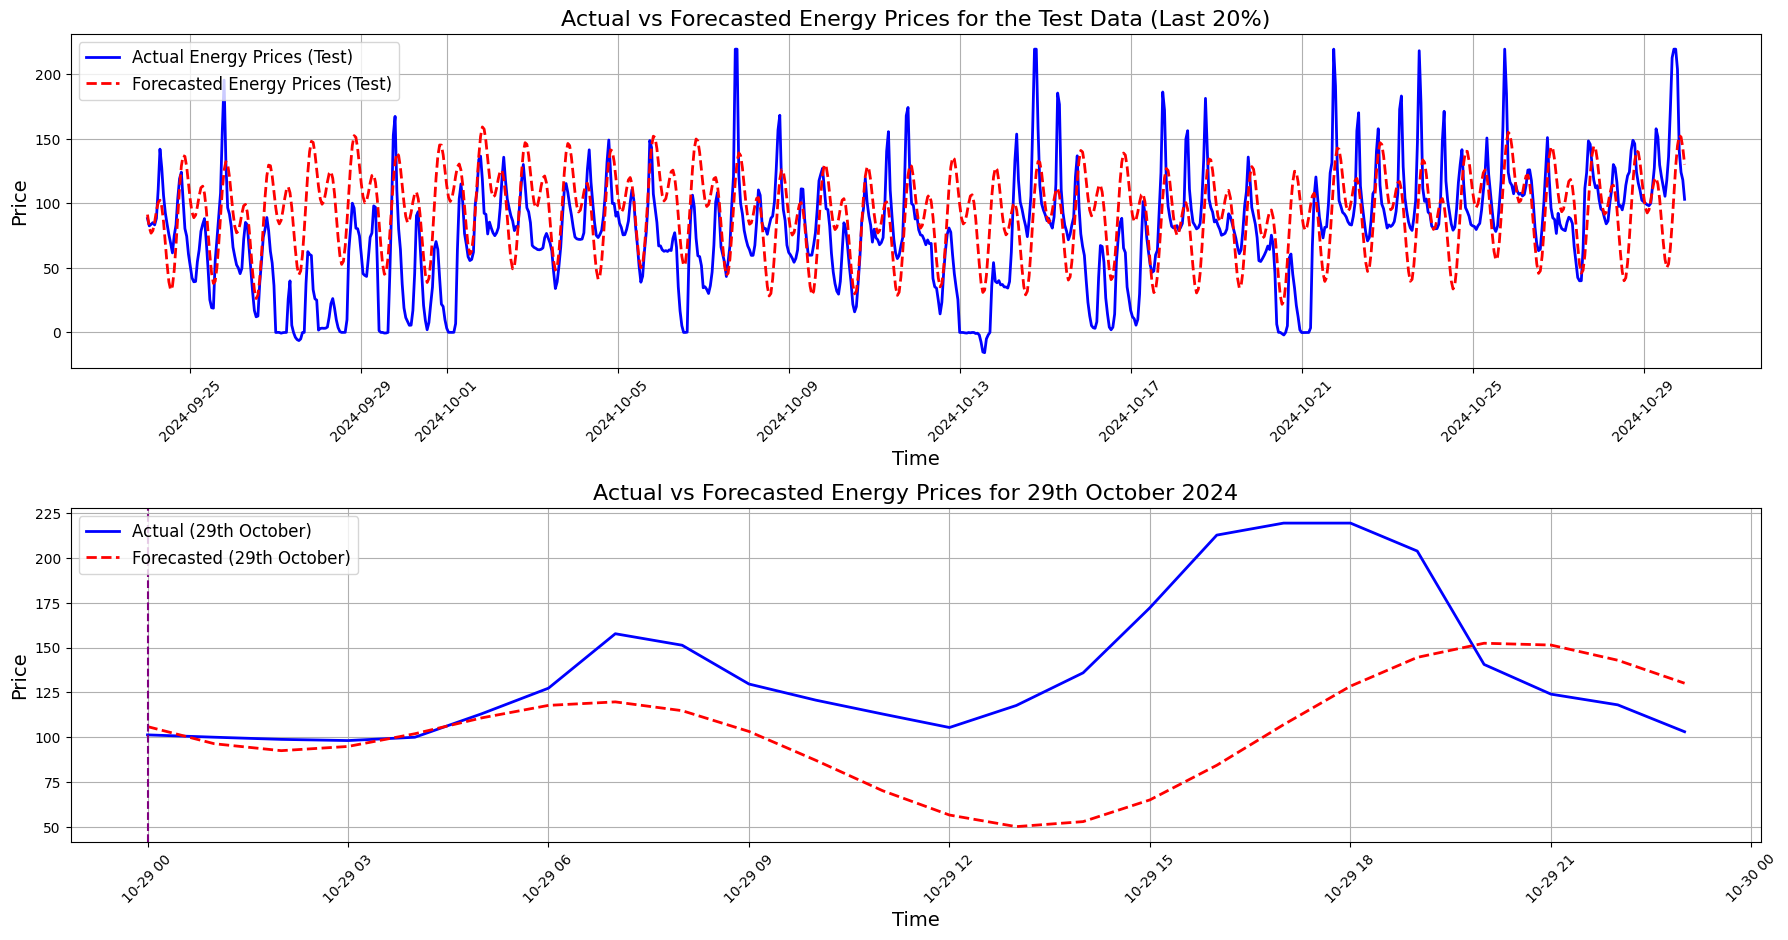

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE Calculation for the Test Period
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data[(merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')]

# Calculate RMSE for the entire test period
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for the test period: {rmse}")

# Calculate RMSE for 29th October 2024
rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024: {rmse_29th_october}")

# Set up a larger figure size for better clarity
plt.figure(figsize=(18, 14))  # Larger figure to accommodate all plots cleanly

# # Plot the entire data (train + test) with forecasted and actual values
# plt.subplot(3, 1, 1)
# plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue', linewidth=2)
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices', color='red', linestyle='dashed', linewidth=2)
# plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months", fontsize=16)
# plt.xlabel("Time", fontsize=14)
# plt.ylabel("Price", fontsize=14)
# plt.xticks(rotation=45)
# plt.legend(loc='upper left', fontsize=12)
# plt.grid(True)

# Plot only the test data (last 20%)
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices (Test)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Plot 29th October 2024 data separately
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast[forecast['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue', linewidth=2)
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Adjust vertical space between the subplots
plt.subplots_adjust(hspace=0.4)  # Increase spacing between subplots


# Optional: Adding a vertical line for 29th October 2024
plt.axvline(pd.to_datetime('2024-10-29'), color='purple', linestyle='--', label='29th October 2024')

# Tighten layout to avoid clipping
plt.tight_layout()

# Show the final plots
plt.show()


# Modeling COVID-19 lockdowns, Holidays and Special Events

In [94]:
# Load and prepare the dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Filter data up to 30th October 2024
df = df[df['ds'] <= '2024-10-29 23:59:00']
end_date = df['ds'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)].reset_index(drop=True)

# Clip outliers
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Split data: Use the last 20% as test data, and the first 80% as training data
split_index = int(len(df) * 0.2)  # 80% for training, 20% for testing
test_data = df[:split_index]  # First 80% for training
train_data = df[split_index:]   # Remaining 20% for testing

In [112]:
# Define the lockdowns as one-off holidays
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'war',        'ds': '2022-08-24', 'lower_window': 0, 'ds_upper': '2023-08-10'},
])

# Convert to datetime
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])

lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# Initialize and configure the Prophet model with holidays (lockdowns and special events)
model_with_holidays = Prophet(
    growth='linear',
    daily_seasonality=False,
    changepoint_prior_scale=0.5,
    n_changepoints=5,
    seasonality_mode='additive',
    seasonality_prior_scale=0.01,
    holidays_prior_scale=0.01,
    holidays=lockdowns  # Add lockdowns as holidays
)

# Add custom seasonalities (if necessary)
model_with_holidays.add_seasonality(name='hourly', period=1, fourier_order=2)
model_with_holidays.add_seasonality(name='daily', period=24, fourier_order=12)
model_with_holidays.add_seasonality(name='weekly', period=7*24, fourier_order=1)
model_with_holidays.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
model_with_holidays.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

# Fit the model with holidays
model_with_holidays.fit(train_data)

# Forecast the future values (test period)
future_df = test_data[['ds']]  # Using the test data for future forecasting
forecast_with_holidays = model_with_holidays.predict(future_df)

20:08:49 - cmdstanpy - INFO - Chain [1] start processing
20:08:50 - cmdstanpy - INFO - Chain [1] done processing


In [113]:
# RMSE Calculation
merged_data_with_holidays = pd.merge(test_data[['ds', 'y']], forecast_with_holidays[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data_with_holidays[(merged_data_with_holidays['ds'] >= '2024-10-29 00:00:00') & (merged_data_with_holidays['ds'] <= '2024-10-29 23:59:59')]

# Calculate RMSE for the entire test period
rmse = np.sqrt(mean_squared_error(merged_data_with_holidays['y'], merged_data_with_holidays['yhat']))
print(f"RMSE for the test period (with holidays): {rmse}")

# Calculate RMSE for 29th October 2024
rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024 (with holidays): {rmse_29th_october}")

RMSE for the test period (with holidays): 52.05847385026474
RMSE for 29th October 2024 (with holidays): 45.653743918563094


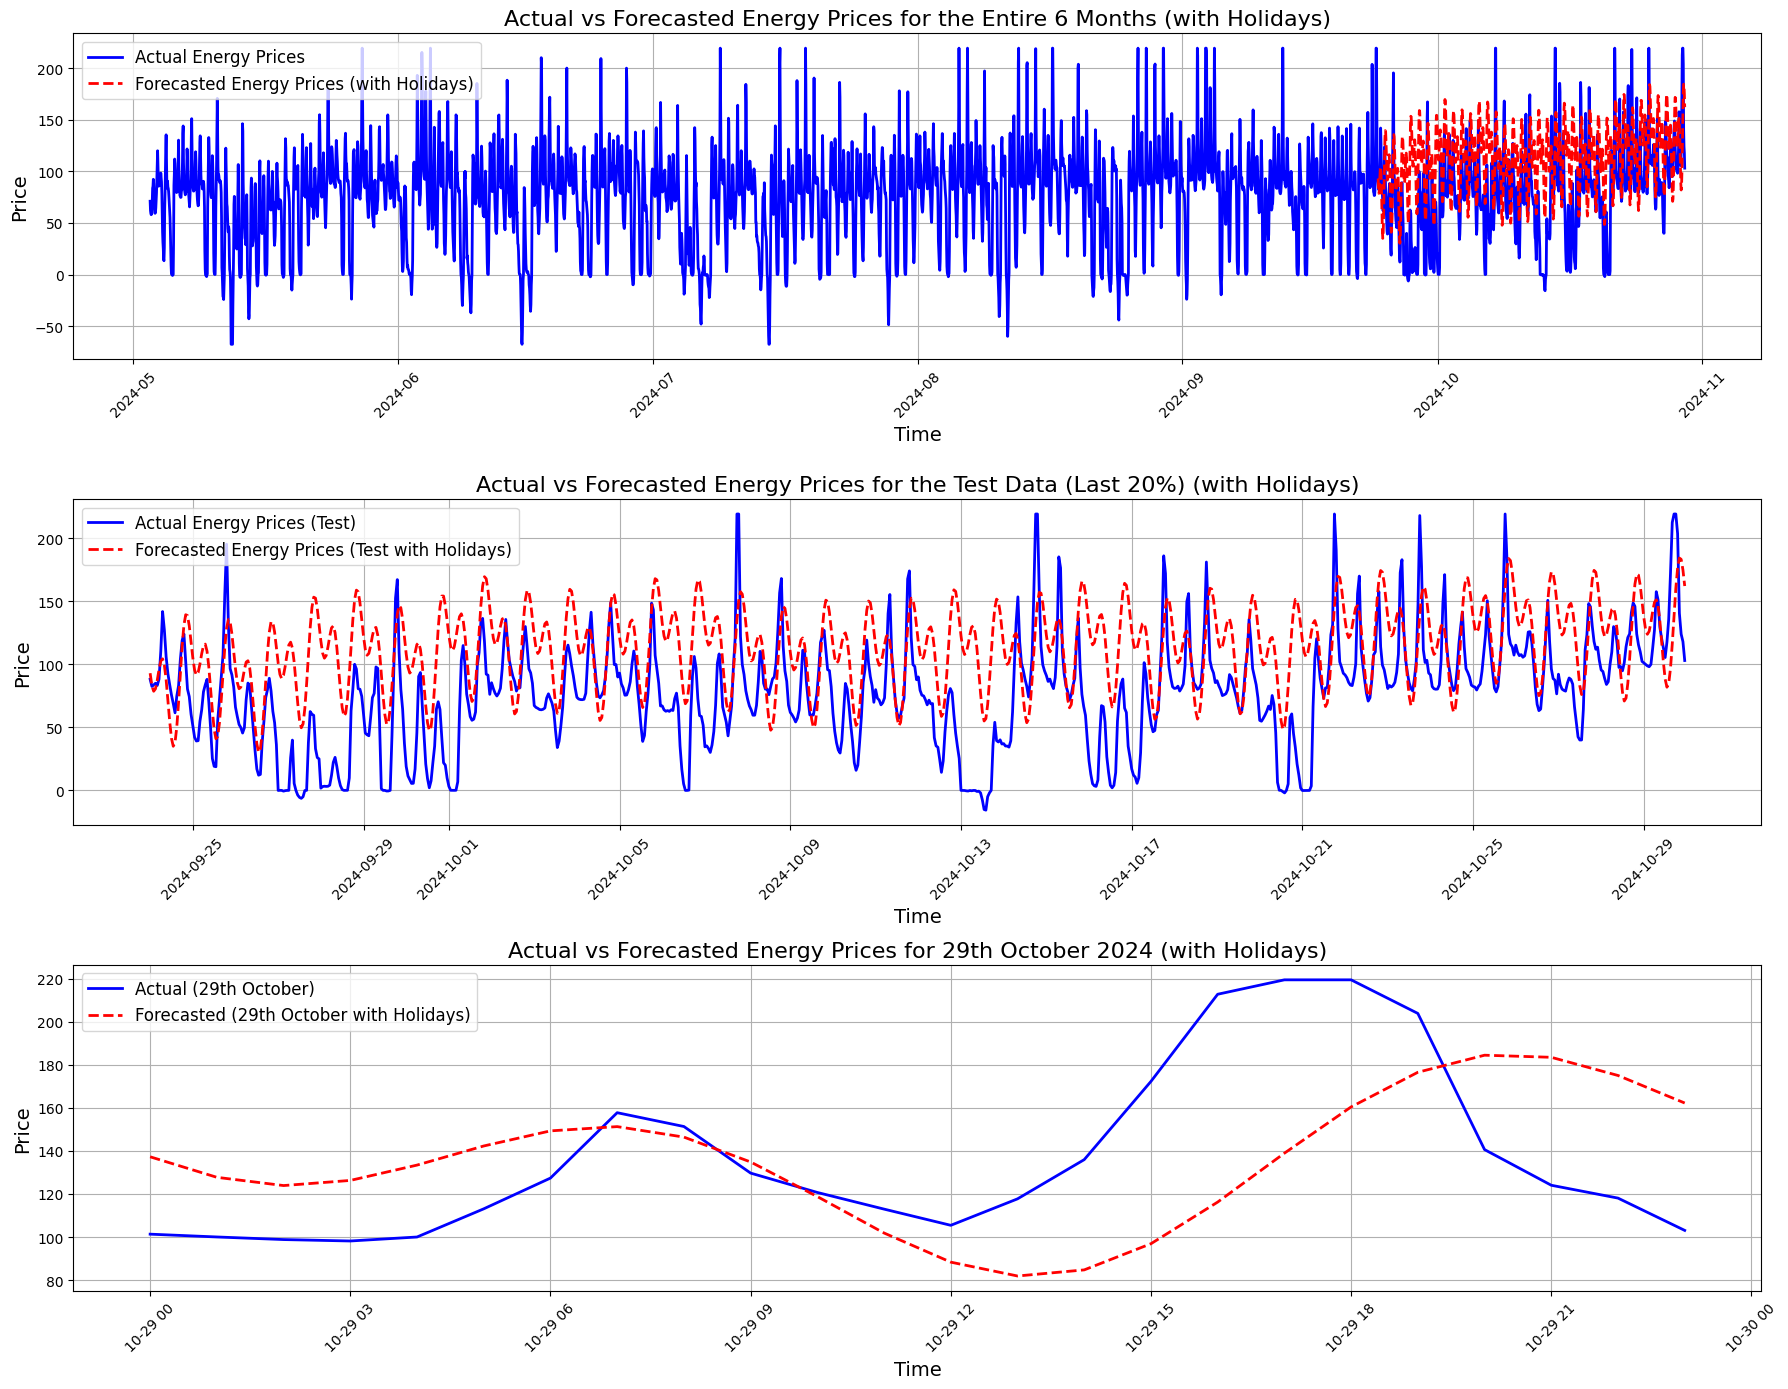

In [100]:
# Plot the entire data with forecasted and actual values
plt.figure(figsize=(18, 14))

# Plot entire data (train + test) with forecast and actual values
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue', linewidth=2)
plt.plot(forecast_with_holidays['ds'], forecast_with_holidays['yhat'], label='Forecasted Energy Prices (with Holidays)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months (with Holidays)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Plot only the test data (last 20%)
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue', linewidth=2)
plt.plot(forecast_with_holidays['ds'], forecast_with_holidays['yhat'], label='Forecasted Energy Prices (Test with Holidays)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%) (with Holidays)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Plot 29th October 2024 data separately
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast_with_holidays[forecast_with_holidays['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue', linewidth=2)
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October with Holidays)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024 (with Holidays)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()
